<h1 align='center'> Rental Listing Interest Levels Prediction<h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:

predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 

### File descriptions
train.json - the training set<br>
test.json - the test set<br>
sample_submission.csv - a sample submission file in the correct format<br>
images_sample.zip - listing images organized by listing_id (a sample of 100 listings)<br>
Kaggle-renthop.7z - (optional) listing images organized by listing_id. Total size: 78.5GB compressed. Distributed by BitTorrent (Kaggle-renthop.torrent). <br>
Data fields<br>
bathrooms: number of bathrooms<br>
bedrooms: number of bathrooms<br>
building_id<br>
created<br>
description<br>
display_address<br>
features: a list of features about this apartment<br>
latitude<br>
listing_id<br>
longitude<br>
manager_id<br>
photos: a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. <br>
price: in USD<br>
street_address<br>
interest_level: this is the target variable. It has 3 categories: 'high', 'medium', 'low'<br>

## Outline:

**I. Introduction** <br>
a) Data Import<br>
b) Data Cleaning<br><br>

**II. Exploratory Data Analysis**<br>

**III. Feature Engineering**<br>

**IV. Modeling**<br>
a) Baseline - Logistic Regression<br>
b) Multiple Models<br>
c) Selected Models - Hyperparameter Tuning<br>
e) What is Happening?<br><br>

**V. Evaluation**<br>
a) Confusion Matrix<br>
b) Error Analysis<br>
c) Insights from the Model



In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, 
                                    learning_curve, RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import re, string

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 16

%matplotlib inline

<br>
<br>
# I. Introduction 

## Data Import

** findings **

- Data have missing values. It is hard to distinguish between pure missing values and empty & zero values. 

In [3]:
ls

MTA/                        data/
Quora_insincere.ipynb       reference/
README.md                   rental_listing.ipynb
RecSys/                     toxic_classification.ipynb
SentiAnal/                  tweet_classification.ipynb


In [4]:
df = pd.read_json('../../rental_listing/train.json')

In [5]:
df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low


In [6]:
print('number of rows:', df.shape[0])
print('number of cols:', df.shape[1])

number of rows: 49352
number of cols: 15


In [7]:
# datatime
df['created'] = pd.to_datetime(df['created'])

In [8]:
# See sum buildings are frequently posted. There are some missing vals
df['building_id'].value_counts().head(3)

0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
Name: building_id, dtype: int64

In [9]:
# See there are managers more active than others
df['manager_id'].value_counts().head(5)

e6472c7237327dd3903b3d6f6a94515a    2533
6e5c10246156ae5bdcd9b487ca99d96a     711
8f5a9c893f6d602f4953fcc0b8e6e9b4     410
62b685cc0d876c3a1a51d63a0d6a8082     402
cb87dadbca78fad02b388dc9e8f25a5b     373
Name: manager_id, dtype: int64

In [10]:
# See listing_id is unique and there is no missing. So every listing is unique (but possibly same places exist)
df['listing_id'].value_counts().head(2)

6819838    1
6975823    1
Name: listing_id, dtype: int64

<br>

## Data Cleaning

In [11]:
# unnecessary columns dropped
drop_cols = 'building_id,display_address,latitude,longitude,street_address,listing_id'.split(',')
df = df.drop(drop_cols, axis=1)

#rename_cols
rename_map = {'created':'time', 'manager_id':'manager', 'interest_level':'int_rate'}
df = df.rename(columns=rename_map)

df.head(3)

,bathrooms,bedrooms,time,description,features,manager,photos,price,int_rate
10,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[],5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,medium
10000,1.0,2,2016-06-12 12:19:27,,"[Doorman, Elevator, Fitness Center, Cats Allow...",7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,low
100004,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...","[Laundry In Building, Dishwasher, Hardwood Flo...",d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,high


In [12]:
# new variable - 1: photo exists, 0: not exist
df['has_photo'] = df['photos'].apply(lambda x: bool(x)).astype('int')
df.drop('photos', axis=1, inplace=True)

# new variable - number of features listed
df['num_feature'] = df['features'].apply(len)
df.drop('features', axis=1, inplace=True)

# Label managers
df['manager'] = df['manager'].factorize()[0]

# reset index
df.reset_index(drop=True, inplace=True)
df.head()

,bathrooms,bedrooms,time,description,manager,price,int_rate,has_photo,num_feature
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,0,3000,medium,1,0
1,1.0,2,2016-06-12 12:19:27,,1,5465,low,1,5
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",2,2850,high,1,4
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,3,3275,low,1,2
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,4,3350,low,1,1


<br>
<br>
# II. Exploratory Data Analysis

## Interest rate proportion, mean price vs. interest Rate 
### Findings 

- Interate rate groups are quite imbalanced. Low group takes up more than 70% of the whole observation.
- Mean price is higher for low interest rate group. More people look up less pricy items. Pretty reasonable.


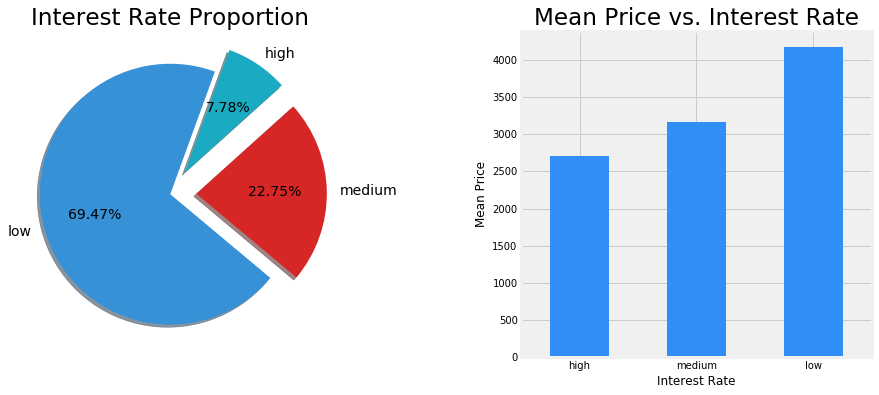

In [13]:
# Interest Rate Proportion
colors = ["#3791D7", "#D72626", "#1AAAC1"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
df['int_rate'].value_counts().plot.pie(explode=[0,0.2, 0.2], autopct='%1.2f%%', 
                                             shadow=True, colors=colors, 
                                             fontsize=14, startangle=70, ax=ax1)

plt.rcParams['font.size'] = 16
# Mean price over interest rates
df.groupby(['int_rate'])['price'].mean().sort_values().plot(kind='bar', ax=ax2, color="#2F8FF7", rot=0)
ax1.set_ylabel('')
ax1.set_title('Interest Rate Proportion')

ax2.set_title('Mean Price vs. Interest Rate')
ax2.set_ylabel('Mean Price')
ax2.set_xlabel('Interest Rate')

plt.subplots_adjust(wspace=0.5)
plt.show()

## Interest Rate vs. Price
### Findings

- Distribution of price is highly clustered. Also, there are outliers. The max value is tens of time more expensive than the 90% highest ones.
- I will make bins to deal with the outliers.

In [14]:
# Let`s see the distribution of the price
for i in range(0, 101, 10):
    print("{} %: ".format(i), np.percentile(df['price'], i))

0 %:  43.0
10 %:  2000.0
20 %:  2350.0
30 %:  2600.0
40 %:  2850.0
50 %:  3150.0
60 %:  3450.0
70 %:  3800.0
80 %:  4500.0
90 %:  5651.800000000003
100 %:  4490000.0


In [15]:
print("price range: $", min(df['price']),"~ $", max(df['price']))

price range: $ 43 ~ $ 4490000


In [16]:
bins = (0, 2500, 4000, float('inf'))
labels = ('low_price', 'medium_price', 'high_price')

df['price_cat'] = pd.cut(df['price'], bins=bins, labels=labels)

In [17]:
df.head(3)

,bathrooms,bedrooms,time,description,manager,price,int_rate,has_photo,num_feature,price_cat
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,0,3000,medium,1,0,medium_price
1,1.0,2,2016-06-12 12:19:27,,1,5465,low,1,5,high_price
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",2,2850,high,1,4,medium_price


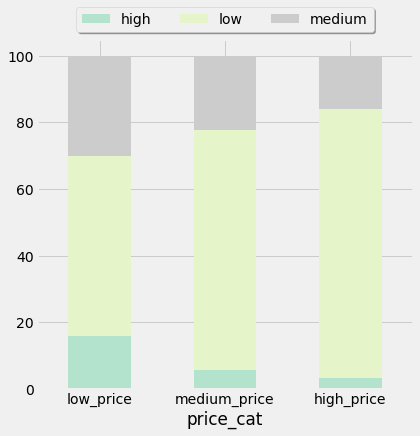

In [19]:
plt.style.use('fivethirtyeight')
crosstab_df = round(pd.crosstab(df['price_cat'], df['int_rate']).apply(lambda x: x/x.sum() * 100, axis=1), 2)
crosstab_df.plot(kind='bar', figsize=(6,6), stacked=True, colormap='Pastel2', rot=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0),
          fancybox=True, shadow=True, ncol=5)
plt.show()

<br>
## Number of rooms vs. interest rate

### Findings:

- There is no obvious difference in the distribution of num_room for each interest rate group.
- Still, lower interest rate groups tend to have more rooms! Places with many rooms are more for big families. Plus, more rooms mean more price in general.

In [20]:
df['num_room'] = df[['bathrooms', 'bedrooms']].sum(axis=1)

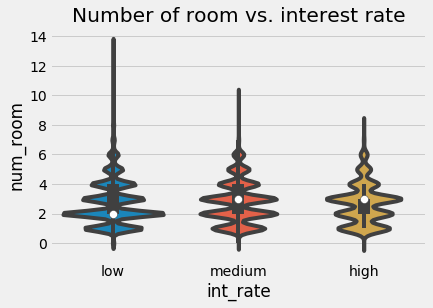

In [21]:
sns.violinplot('int_rate', 'num_room', data=df, order=['low', 'medium', 'high'])
plt.title("Number of room vs. interest rate")
plt.show()

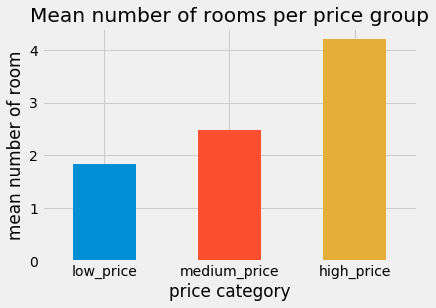

In [22]:
df.groupby('price_cat')['num_room'].mean().sort_values().plot(kind='bar', rot=0)
plt.title('Mean number of rooms per price group')
plt.ylabel('mean number of room')
plt.xlabel('price category')
plt.show()

<br>
# Manager vs. Interest Rate

### Findings

- The experience of the managers do not have much indication on the target.

(0, 200)

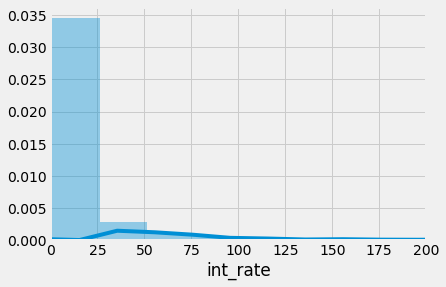

In [23]:
# Number of items per manager
num_items_manager = df.groupby(['manager'])['int_rate'].size()

# Again, most of the managers have listings less than 100
sns.distplot(num_items_manager, bins=100)
plt.xlim(0,200)

In [24]:
for i in range(0, 101, 10):
    print(f"{i:3.0f} %:", np.percentile(num_items_manager, i))

  0 %: 1.0
 10 %: 1.0
 20 %: 1.0
 30 %: 2.0
 40 %: 2.0
 50 %: 4.0
 60 %: 6.0
 70 %: 10.0
 80 %: 16.0
 90 %: 32.0
100 %: 2533.0


In [25]:
bins = (0, 4, 30, float('inf'))
cats = [0, 1, 2]

df['num_items_manager'] = pd.cut(num_items_manager, bins=bins, labels=cats)

<Figure size 864x432 with 0 Axes>

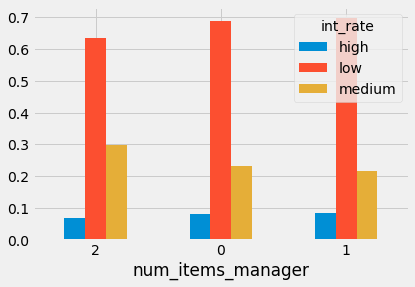

In [26]:
plt.figure(figsize=(12,6))
groupby_num = (df.groupby(['num_items_manager'])['int_rate'].value_counts()/
               df.groupby(['num_items_manager'])['int_rate'].size()).unstack().sort_values('high').plot(kind='bar', rot=0)

<br>
# Photo vs. Targets

- Listings with photos drows more interest! Also, tends to be pricy.

In [27]:
df.groupby(['has_photo'])['price'].mean()

has_photo
0    5457.136929
1    3701.580755
Name: price, dtype: float64

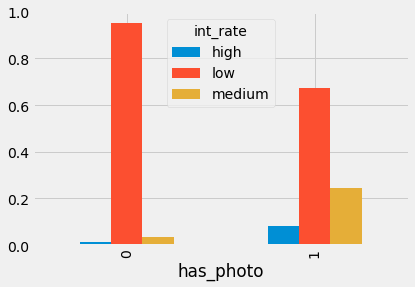

In [28]:
(df.groupby(['has_photo'])['int_rate'].value_counts()/
 df.groupby(['has_photo'])['int_rate'].size()).unstack().plot(kind='bar')

<br>
## Word Length vs Targets

In [29]:
df['text_length'] = df['description'].str.len()

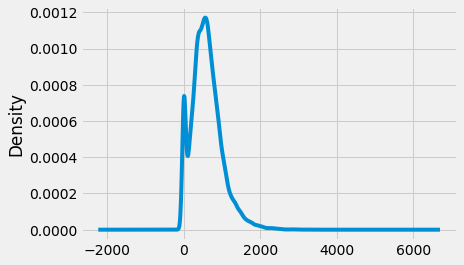

In [30]:
df['text_length'].plot.kde()

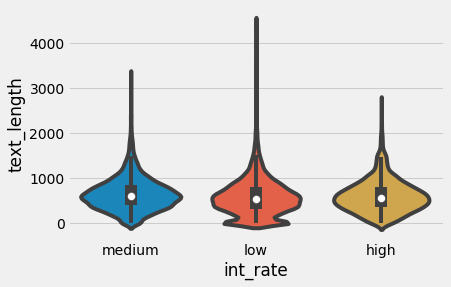

In [31]:
sns.violinplot('int_rate', 'text_length', data=df)

<br>
<br>
# III. Feature Engineering

## Before Starting:

The data has a textual feature. Description column constains introductory statements about the listed items. I will apply tf-idf vectorizer with snowball stemmer to represent the text as numeric vectors. Then I will use truncated SVD to gain the most imformative linear combinations of the vectors.

In [32]:
pd.options.display.max_colwidth=300
df['description'].head(3)

0    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in ...
1                                                                                                                                                                                                                                                                                                               
2    Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Buildi...
Name: description, dtype: object

In [33]:
# The number of missing values are not too many. Let`s remove the rows.
sum((~df['description'].str.replace(' ', '').apply(lambda x: bool(x))).astype(int))

3333

In [34]:
# Delete the rows with missing text
df = df.loc[df['description'].str.replace(' ', '').apply(lambda x: bool(x)),:]

df.head(3)

,bathrooms,bedrooms,time,description,manager,price,int_rate,has_photo,num_feature,price_cat,num_room,num_items_manager,text_length
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in ...,0,3000,medium,1,0,medium_price,4.5,2,588
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Buildi...",2,2850,high,1,4,medium_price,2.0,2,691
3,1.0,1,2016-04-18 02:22:02,"Building Amenities - Garage - Garden - fitness room - laundry room -rooftop deck .<br /><br />Located in midtown East - High energy area - plenty of Bars and restaurants to choose from - within walking distance to the transit E,M,6,7<br /><br />This Apartment also feature a renovated kitchen wit...",3,3275,low,1,2,medium_price,2.0,2,492


In [35]:
# Select features for further modeling
features = "bathrooms,bedrooms,price_cat,has_photo,description".split(',')

# Label
X = df[features]
X['price_cat'] = X['price_cat'].map({'medium_price':1, 'high_price':2, 'low_price':0})

y = df['int_rate']
y = y.map({'low':0, 'medium':1, 'high':2}).values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Text Vectorizers & Feature Selection Algorithms

In [37]:
# Stemmer + TFIDF
stemmer = nltk.stem.SnowballStemmer('english')

# Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


pipe = Pipeline([('vec', StemmedTfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, analyzer='word')), 
                 ('svd', TruncatedSVD(n_components=10, random_state=42))])

In [38]:
# Tokenize
def preprocessing(titles):
    num_titles = titles.size
    
    clean_titles = []
    
    stops = set(stopwords.words("english"))
    
    for i in range(0, num_titles):
        #letters_only = re.sub("[^a-zA-Z]", " ", titles[i]) 
        words = titles[i].lower().split()
        words = [w.lower() for w in words if not w in stops]  
        clean_titles.append(" ".join(words))
        
    return clean_titles

# Tf-idf
def tf_idf(titles, ngram_range=(1,1), max_df=1.0, min_df=1, norm='l2'):

    tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                        max_df=max_df, min_df=min_df, norm=norm)
    vectors = tf_idf_vectorizer.fit_transform(titles)
    
    return vectors, tf_idf_vectorizer # This transformer will be used to vectorize test data again.

# counter
def count(titles, ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None, binary=False):
    
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df,
                                           max_features=max_features, binary=binary)
    vectors = count_vectorizer.fit_transform(titles)
    
    return vectors, count_vectorizer

In [39]:
# Feature Selection
def features_chi2(features, labels, n_features=5000):
    chi2_model = SelectKBest(chi2, k=n_features)
    new_features = chi2_model.fit_transform(features, labels)
    return new_features, chi2_model

def features_information_gain(features, labels, max_features=1000):
    tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_features=max_features)
    tree_clf = tree_clf.fit(features, labels)
    inf_gain = SelectFromModel(tree_clf, prefit=True)
    new_features = inf_gain.transform(features)
    return new_features, inf_gain
    
def features_lsa(features,n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    new_features = lsa.fit_transform(features)
    return new_features, lsa

In [40]:
X_train = np.concatenate([X_train.drop('description', axis=1).values, \
                          pipe.fit_transform(X_train['description'])], axis=1)
X_test = np.concatenate([X_test.drop('description', axis=1).values, \
                         pipe.fit_transform(X_test['description'])], axis=1)

<br>
<br>

# IV. Modeling

##  Baseline - Logistic Regression

### Before start:

- Beware of the imbalance in the classes! This imbalance makes it fundamentally difficult to evaluate fitted models. In this case, accuracy metrics is not a good metircs in general.

In [164]:
print("class 1: {}, class 2: {}, class 3: {}".format
      (np.bincount(y_train)[0], np.bincount(y_train)[1], np.bincount(y_train)[2]))

class 1: 24961, class 2: 8836, class 3: 3018


In [165]:
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
lr = LogisticRegression()

# Fit the model
acc_val = cross_val_score(lr, X_train, y_train, scoring='f1_weighted', cv=kfold)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)

print('validation accuracy: {} +- {}'.format(acc_mean, 2*acc_std))

validation accuracy: 0.5789748093072998 +- 0.0015336192282683246


### Learning Curve

In [47]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param, scoring):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel(scoring)
    plt.title("{} {} vs. {}".format(name_pred, scoring, name_param))
    plt.show()

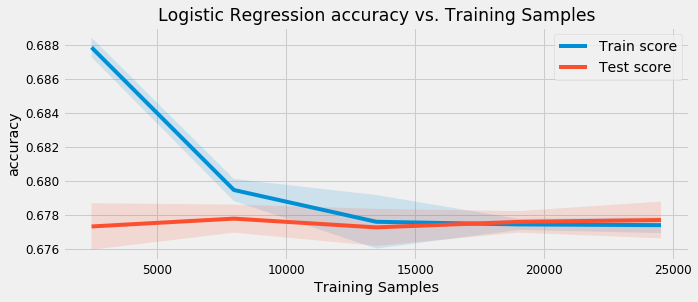

In [169]:
# Learning Curve
def plot_learning_curve(predictor, X, y, name_param, name_pred, scoring='accuracy', cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, scoring=scoring, cv=cv)
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param, scoring)
    
plot_learning_curve(lr, X_train, y_train, "Training Samples", "Logistic Regression", scoring="accuracy")

<br>
<br>
# Trying Multiple Models

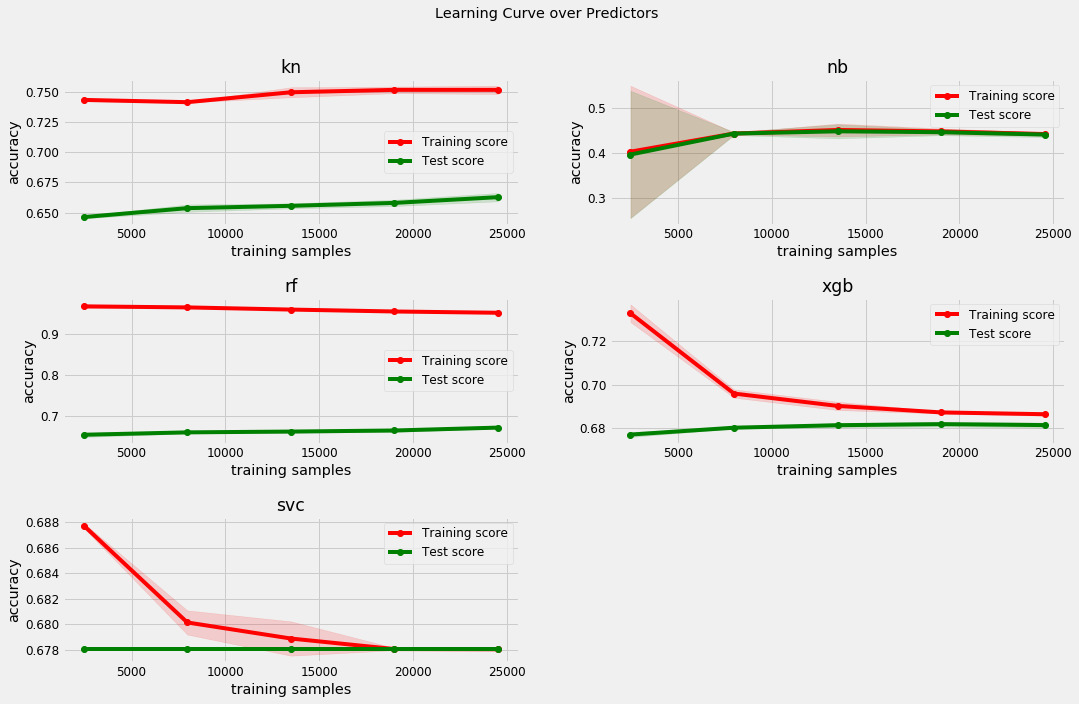

In [183]:
def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], scoring='accuracy', cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, 
                                                                                    scoring=scoring, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, sharex=False, sharey=False)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_xlabel('training samples')
        ax.set_ylabel(scoring)
        ax.set_title(names[i])
    

predictors = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo')]
pred_names = ['kn', 'nb', 'rf', 'xgb', 'svc']

plot_multiple_learning_curve(predictors, X_train, y_train, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names, scoring='accuracy', cv=3)

# Selected Models

- Based on the learning curves, I believe random forest or xgboosting will make the highest performance over the classifiers.
- In the following section, I will tune the hyperparameters of the two models using random search.

In [42]:
# Random Forest
kfold = StratifiedKFold(n_splits=3, random_state=42)
rf_param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, rf_param_grid, n_jobs = -1, 
                        scoring = 'f1_weighted', cv = kfold, 
                        n_iter = 10, verbose = 1)
rf_rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94, ... 49, 50], 'min_samples_split': [2, 5, 10], 'bootstr

In [43]:
# XGBoost
xg_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xg = XGBClassifier()
xg_rs = RandomizedSearchCV(xg, xg_param_grid, 
                                   n_iter=100, scoring='f1_weighted', 
                                   n_jobs=-1, cv=kfold, verbose=3)
xg_rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_weighted', verbose=3)

<br>

## What is happening? - validation curve

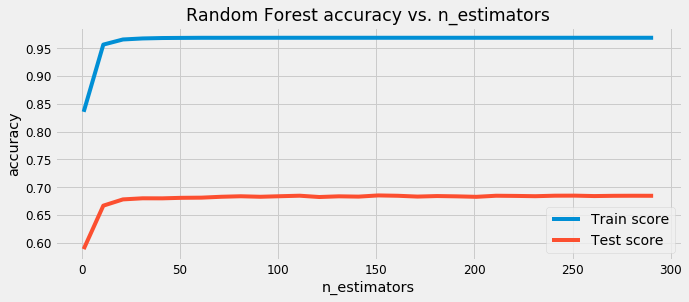

In [48]:
# Validation Curve
from sklearn.model_selection import validation_curve
def plot_val_curve(predictor, X, y, name_param, name_pred, param_space, scoring='accuracy', cv=3):
    train_scores, test_scores = validation_curve(predictor, X, y, name_param,
                                               param_space, scoring=scoring, cv=cv)
    call_plot(param_space, train_scores, test_scores, name_pred, name_param, scoring)
    
plot_val_curve(RandomForestClassifier(), X_train, y_train, 'n_estimators',
               'Random Forest', range(1, 300, 10), scoring='accuracy')

<br>
<br>

# V. Evaluation

## Precision, Recall, and Confusion Matrix

Accuracy : 0.5557366362451108
Classification Report
              precision    recall  f1-score   support

           0     0.8003    0.6511    0.7180      6240
           1     0.3534    0.2847    0.3154      2209
           2     0.1802    0.5603    0.2727       755

   micro avg     0.5557    0.5557    0.5557      9204
   macro avg     0.4446    0.4987    0.4354      9204
weighted avg     0.6422    0.5557    0.5849      9204



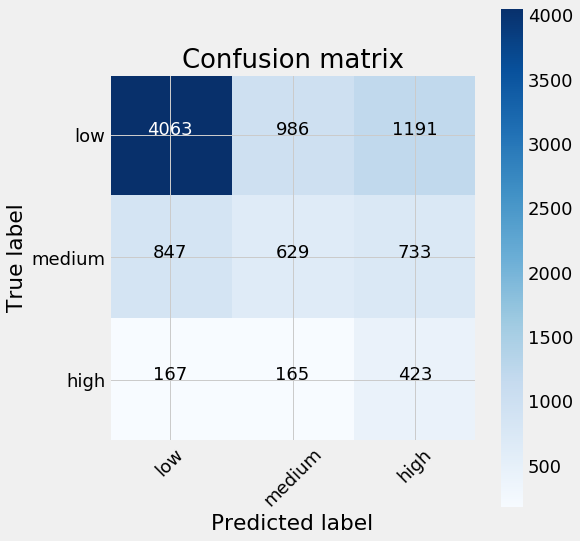

In [49]:
# Full-Report
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'
    
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes):
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x)
    y_true = y_true

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)  

clf_rf = rf_rs.best_estimator_
full_report(clf_rf, X_test, y_test, ['low', 'medium', 'high'])

Accuracy : 0.6831812255541069
Classification Report
              precision    recall  f1-score   support

           0     0.7000    0.9694    0.8129      6240
           1     0.4280    0.1037    0.1669      2209
           2     0.3704    0.0132    0.0256       755

   micro avg     0.6832    0.6832    0.6832      9204
   macro avg     0.4995    0.3621    0.3351      9204
weighted avg     0.6077    0.6832    0.5933      9204



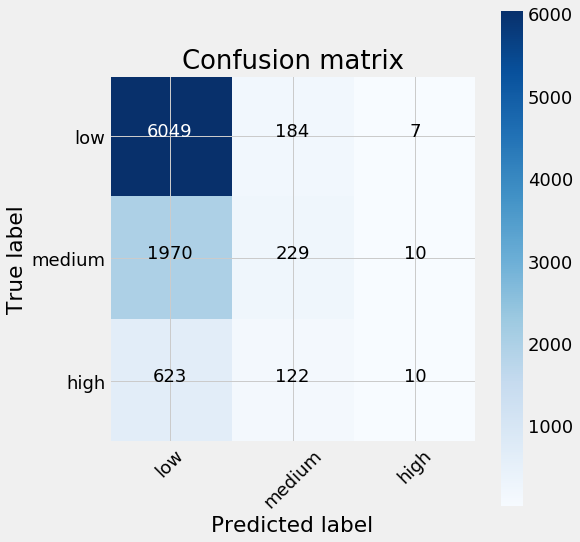

In [50]:
clf_xg = xg_rs.best_estimator_
full_report(clf_xg, X_test, y_test, ['low', 'medium', 'high'])

<br>

## Error Analysis

#### Findings

- The most common error occurs when the model predicts 'medium' labels as 'low' labels. It is a natural consequence considering that there are much more number of 'low' labels and 'medium' would be harder to be distinguished from them than 'hard' labels.
- This error analysis gives a further insight in how to improve the model performance. It is worth trying to create feature engineering process to seperate 'low' and 'medium' labels.

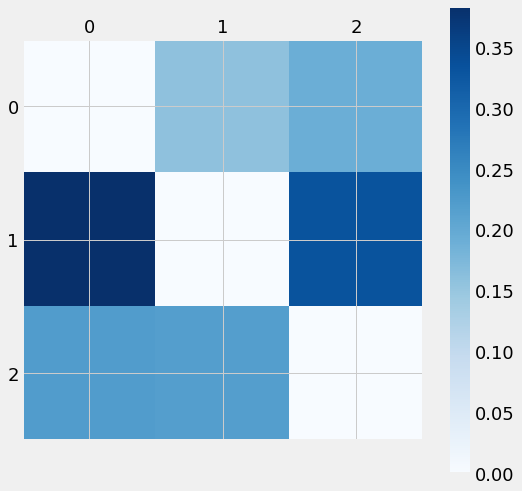

In [51]:
# Confusion Matrix
y_pred = clf_rf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

# Closer look on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

## Conclusion

- Starting with data cleaning and visualization, this notebook covered a whole step of producing a classification model on mixed-type features. I applied natural language processing, random search for hyper-parameter tuning, and graphical evaluation of the final model.
- As the result, the final model achieved more than 59% of weighted f1 score. In this case, weighted f1 score gives more precise assessment of the model as the classes are imbalanced.
- It seems that the random forest model did not converge to the maximum performance. If I could collect more data, the performance will be further improved.
- Finally, I would like to figure out a way to seperate 'low' class and 'medium' class where the most number of misclassifications occured. It will be the next step of production.